# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

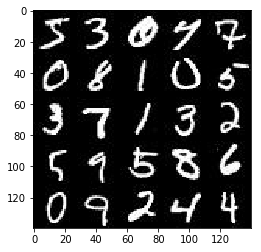

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

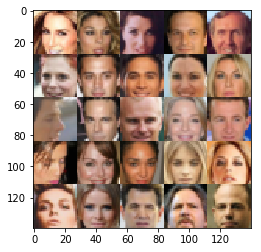

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_img')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """


    initializer=tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer = initializer)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer = initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(inputs=bn2, rate=0.5,training=True, name="dropout2")
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer = initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        dropout3 = tf.layers.dropout(inputs=bn3, rate=0.5,training=True, name="dropout3")
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    initializer=tf.contrib.layers.xavier_initializer()

    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,kernel_initializer = initializer)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer = initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same', kernel_initializer = initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same', kernel_initializer = initializer)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_img, input_z, learning_rate_ph = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_img, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps, print_every, show_every = 0, 10, 100  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_img: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_img: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_img: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5214... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.5980
Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 1.7307... Generator Loss: 0.3396
Epoch 1/2... Discriminator Loss: 1.8450... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 2.0321
Epoch 1/2... Discriminator Loss: 2.9957... Generator Loss: 0.0817
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 1.3286


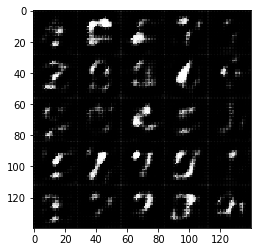

Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 0.3363
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5213
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 1.3207
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 1.4006
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.9313... Generator Loss: 0.2169
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.2363
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 2.1251


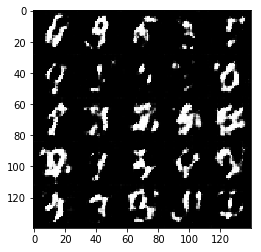

Epoch 1/2... Discriminator Loss: 1.8089... Generator Loss: 0.2440
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.3650
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.7796... Generator Loss: 1.3322
Epoch 1/2... Discriminator Loss: 1.9994... Generator Loss: 0.2831
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 3.5061


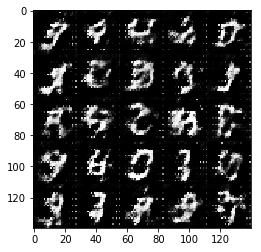

Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.4131
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.7769... Generator Loss: 2.9306
Epoch 1/2... Discriminator Loss: 2.2377... Generator Loss: 1.9885
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 0.5824
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 1.5665


Epoch 1/2... Discriminator Loss: 1.7028... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.4585
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.2622
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.5045


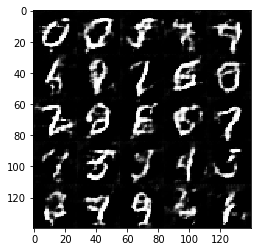

Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 2.1845... Generator Loss: 0.1845
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.8010
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.7549
Epoch 1/2... Discriminator Loss: 1.7189... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 2.3471
Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.3298
Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 1.4001
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.3376


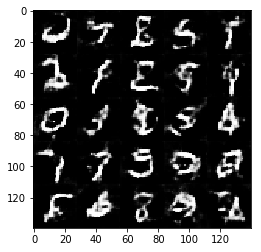

Epoch 1/2... Discriminator Loss: 2.4677... Generator Loss: 0.1685
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 1.1121
Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.9729... Generator Loss: 2.6547
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.4429
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.9669


Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.3480
Epoch 1/2... Discriminator Loss: 1.7618... Generator Loss: 0.2448
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 2.3056... Generator Loss: 0.1240
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 3.3781


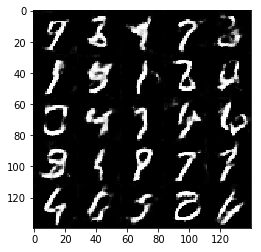

Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.0093
Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 0.4041
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 2.5677... Generator Loss: 0.0968
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 0.3817... Generator Loss: 1.7946
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 0.5580
Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 0.3844
Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 1.7428


Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 0.7272... Generator Loss: 1.4113
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.7190
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.5360
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.3726
Epoch 1/2... Discriminator Loss: 2.2548... Generator Loss: 0.1521


Epoch 1/2... Discriminator Loss: 2.0777... Generator Loss: 3.6489
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 1.1710
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.6090
Epoch 1/2... Discriminator Loss: 1.7189... Generator Loss: 0.3002
Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.3160
Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 1.0726
Epoch 1/2... Discriminator Loss: 2.2605... Generator Loss: 0.2458


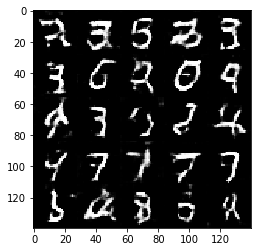

Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 0.6492... Generator Loss: 1.3240
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 1.4499
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 2.7060... Generator Loss: 0.1470
Epoch 1/2... Discriminator Loss: 0.8736... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.2649


Epoch 1/2... Discriminator Loss: 1.7523... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 0.5118... Generator Loss: 1.9153
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 2.6324
Epoch 1/2... Discriminator Loss: 1.7310... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 1.5812
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.5645
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 2.2079... Generator Loss: 0.4056
Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 2.1782


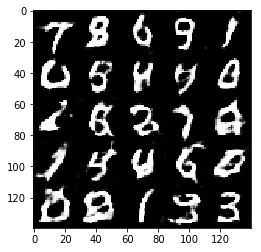

Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 1.8556
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 0.9176
Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 1.9331
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 1.2474


Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 3.2692... Generator Loss: 0.0601
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.2659
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.0476
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.3783
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 1.4852


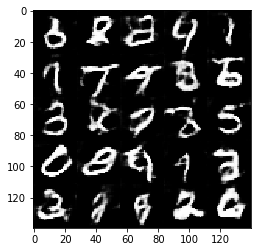

Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 1.7658
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.6625... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 0.7061... Generator Loss: 2.4217
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.8299


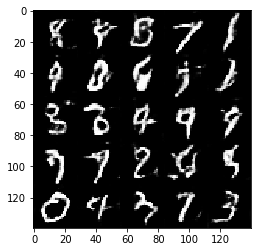

Epoch 1/2... Discriminator Loss: 2.5345... Generator Loss: 0.1395
Epoch 1/2... Discriminator Loss: 2.5405... Generator Loss: 5.7435
Epoch 1/2... Discriminator Loss: 1.8269... Generator Loss: 0.3059
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 1.8024
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 1.6482
Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 1.0557
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 1.2512
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.1657


Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 1.4418... Generator Loss: 0.4295
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.7864... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 1.5229
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 1.8624


Epoch 1/2... Discriminator Loss: 1.4841... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 3.6478
Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.1850
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 1.4011


Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 0.5338... Generator Loss: 1.6259
Epoch 1/2... Discriminator Loss: 2.3856... Generator Loss: 0.1888
Epoch 1/2... Discriminator Loss: 2.2207... Generator Loss: 0.4953
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.4265
Epoch 1/2... Discriminator Loss: 1.6851... Generator Loss: 3.8343
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.7970


Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 4.3232
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 1.0457
Epoch 1/2... Discriminator Loss: 1.8115... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 3.2137... Generator Loss: 0.0767
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 1.2945
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 0.5026... Generator Loss: 1.6339
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 1.2253
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.7804


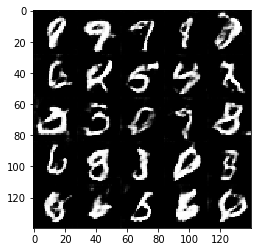

Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 2.3619
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 1.3636... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.8280
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.9479
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.0830


Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.5982
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.4307
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 0.7182
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.7573
Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 3.3551
Epoch 2/2... Discriminator Loss: 2.4045... Generator Loss: 0.2591
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.5083... Generator Loss: 0.4232


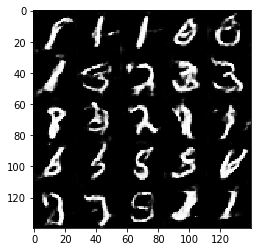

Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.4810
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 2.7224
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.4966... Generator Loss: 0.4116
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.8272
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 1.8058


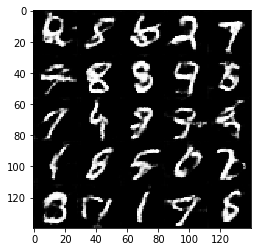

Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.5640
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.6799
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 1.7330... Generator Loss: 0.3829
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 3.6388... Generator Loss: 0.0816
Epoch 2/2... Discriminator Loss: 1.5407... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.9724... Generator Loss: 0.3036
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.5016


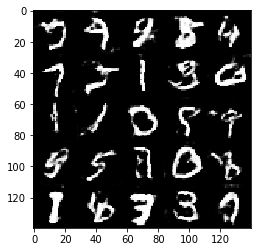

Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 1.4353
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.5899
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 2.2237
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 0.3742... Generator Loss: 1.9657


Epoch 2/2... Discriminator Loss: 1.8995... Generator Loss: 0.3842
Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 2.1998... Generator Loss: 0.3807
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 0.5314... Generator Loss: 2.4842
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.0812
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 2.0900... Generator Loss: 0.2018
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.2596


Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 1.8765... Generator Loss: 0.4052
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.4337
Epoch 2/2... Discriminator Loss: 3.2192... Generator Loss: 0.1199
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.9090
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 1.2031


Epoch 2/2... Discriminator Loss: 0.2523... Generator Loss: 2.2133
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.3088
Epoch 2/2... Discriminator Loss: 0.2707... Generator Loss: 2.0066
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 0.6467... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 1.0820
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.9513


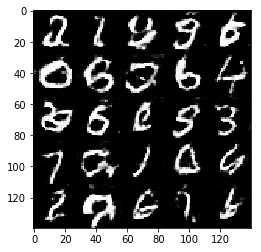

Epoch 2/2... Discriminator Loss: 0.4036... Generator Loss: 3.7564
Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 1.7219
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 1.6305
Epoch 2/2... Discriminator Loss: 0.1889... Generator Loss: 2.8577
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 1.7531
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 0.1323... Generator Loss: 3.2377
Epoch 2/2... Discriminator Loss: 0.2550... Generator Loss: 2.1335
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.4967


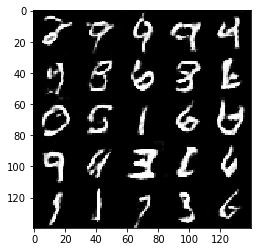

Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.2345
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.2688
Epoch 2/2... Discriminator Loss: 0.3133... Generator Loss: 4.4502
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 2.1582
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.4496
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.4085


Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.6626... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.0308
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 5.1879


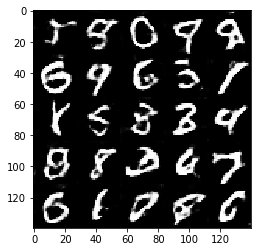

Epoch 2/2... Discriminator Loss: 2.0668... Generator Loss: 0.4006
Epoch 2/2... Discriminator Loss: 1.7458... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 5.2980
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 0.4660
Epoch 2/2... Discriminator Loss: 1.6315... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 2.5872
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 1.7545


Epoch 2/2... Discriminator Loss: 1.5323... Generator Loss: 0.5464
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 0.2807... Generator Loss: 2.4772
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.2199
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 2.0898
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 0.1386... Generator Loss: 3.5823
Epoch 2/2... Discriminator Loss: 1.9054... Generator Loss: 0.3647


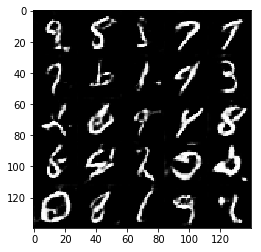

Epoch 2/2... Discriminator Loss: 1.9240... Generator Loss: 0.3473
Epoch 2/2... Discriminator Loss: 0.9752... Generator Loss: 1.2971
Epoch 2/2... Discriminator Loss: 2.0035... Generator Loss: 0.5058
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.4537
Epoch 2/2... Discriminator Loss: 2.5870... Generator Loss: 0.1734
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 1.4697... Generator Loss: 0.4616
Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.9634


Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 0.9232
Epoch 2/2... Discriminator Loss: 1.7839... Generator Loss: 0.3190
Epoch 2/2... Discriminator Loss: 0.2682... Generator Loss: 2.2179
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 1.9643
Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 1.8873
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.8454... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.6437


Epoch 2/2... Discriminator Loss: 1.0648... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 0.2995... Generator Loss: 2.0924
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 6.6101
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 2.2543
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 4.0431
Epoch 2/2... Discriminator Loss: 2.7618... Generator Loss: 8.6641
Epoch 2/2... Discriminator Loss: 1.6623... Generator Loss: 0.3544
Epoch 2/2... Discriminator Loss: 2.4058... Generator Loss: 0.1901
Epoch 2/2... Discriminator Loss: 1.2978... Generator Loss: 0.8594


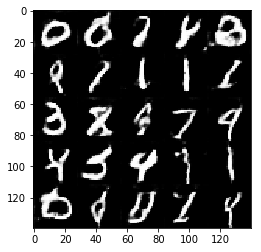

Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.1862
Epoch 2/2... Discriminator Loss: 0.3281... Generator Loss: 2.9010
Epoch 2/2... Discriminator Loss: 0.6228... Generator Loss: 1.7645
Epoch 2/2... Discriminator Loss: 0.3236... Generator Loss: 2.1652
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 2.1085
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 4.5749
Epoch 2/2... Discriminator Loss: 1.7691... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.6869... Generator Loss: 0.4879
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 1.7086... Generator Loss: 0.4832


Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.0966
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 2.4589
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.0979
Epoch 2/2... Discriminator Loss: 0.2796... Generator Loss: 2.3235
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.0444
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.0701
Epoch 2/2... Discriminator Loss: 0.2229... Generator Loss: 2.6209
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 0.8768


Epoch 2/2... Discriminator Loss: 0.3327... Generator Loss: 1.7088
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 1.6266... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 2.2815... Generator Loss: 0.2338
Epoch 2/2... Discriminator Loss: 2.2492... Generator Loss: 0.2377
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 0.4356... Generator Loss: 2.0682
Epoch 2/2... Discriminator Loss: 0.4801... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 1.2078
Epoch 2/2... Discriminator Loss: 0.4121... Generator Loss: 2.0110


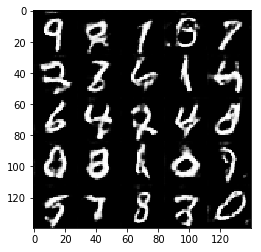

Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 2.3033... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 1.7841... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 2.4922
Epoch 2/2... Discriminator Loss: 3.5672... Generator Loss: 0.0807
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.3556
Epoch 2/2... Discriminator Loss: 0.5746... Generator Loss: 1.5832


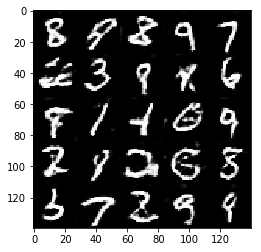

Epoch 2/2... Discriminator Loss: 0.1832... Generator Loss: 3.3212
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 2.0451... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 1.4021
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 0.2019... Generator Loss: 2.3370
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 0.9997


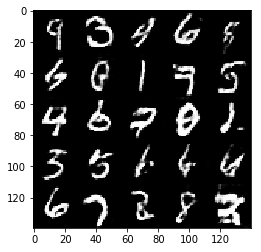

Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 0.5391... Generator Loss: 1.3858
Epoch 2/2... Discriminator Loss: 0.6443... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 1.9200
Epoch 2/2... Discriminator Loss: 2.0581... Generator Loss: 0.3359
Epoch 2/2... Discriminator Loss: 1.8426... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 1.4265


In [12]:
batch_size = 28
z_dim = 128
learning_rate = 0.0028
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8509... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 3.8168... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 2.5355... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 5.7613... Generator Loss: 0.0170
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.2845
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 5.9903
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 2.4991
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 3.8500


Epoch 1/1... Discriminator Loss: 0.0644... Generator Loss: 3.2961
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 2.9880
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 4.5517
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 3.7131
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 4.6823
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 4.9455
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.4258
Epoch 1/1... Discriminator Loss: 8.2761... Generator Loss: 9.1845
Epoch 1/1... Discriminator Loss: 0.2167... Generator Loss: 2.9136
Epoch 1/1... Discriminator Loss: 7.0766... Generator Loss: 0.0031


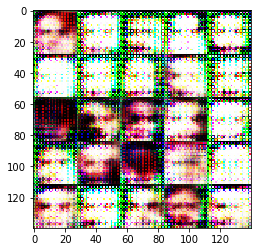

Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 4.9351
Epoch 1/1... Discriminator Loss: 0.2987... Generator Loss: 2.4167
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 1.9935
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 4.0709
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 3.6165
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 2.5780... Generator Loss: 0.1144
Epoch 1/1... Discriminator Loss: 0.0353... Generator Loss: 4.2824
Epoch 1/1... Discriminator Loss: 5.2939... Generator Loss: 9.3829
Epoch 1/1... Discriminator Loss: 0.1089... Generator Loss: 3.0355


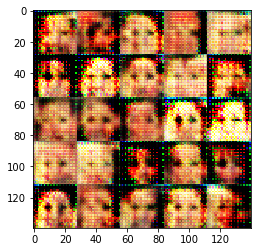

Epoch 1/1... Discriminator Loss: 0.1620... Generator Loss: 2.1259
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 4.2601
Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 2.5625
Epoch 1/1... Discriminator Loss: 6.2380... Generator Loss: 9.6184
Epoch 1/1... Discriminator Loss: 0.2769... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 6.0224
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 5.7908
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 3.3812
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 4.6494
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.7631


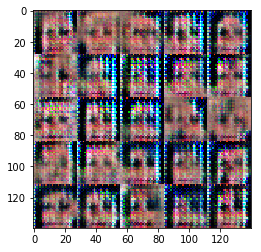

Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 6.6647
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 3.5217
Epoch 1/1... Discriminator Loss: 0.0181... Generator Loss: 4.8122
Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 3.5998
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 7.7791
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 5.0258
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.8726
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 6.8857
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 4.8709
Epoch 1/1... Discriminator Loss: 3.7348... Generator Loss: 0.3211


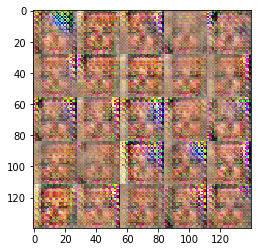

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 1.8598... Generator Loss: 3.5156
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7034


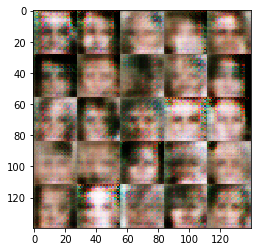

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7973


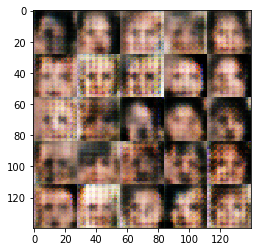

Epoch 1/1... Discriminator Loss: 2.0773... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5661


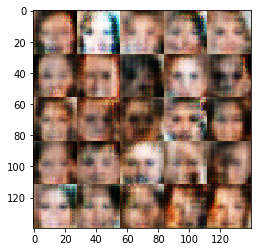

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.3816
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.3245
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7013


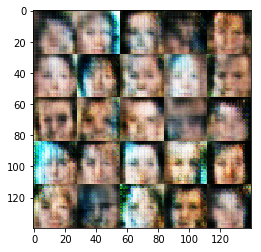

Epoch 1/1... Discriminator Loss: 1.9052... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 2.0634... Generator Loss: 1.8206
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.7029


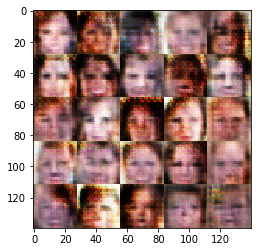

Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9970


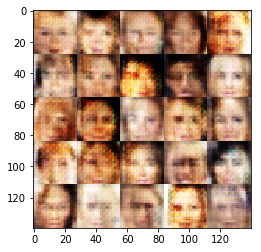

Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6567


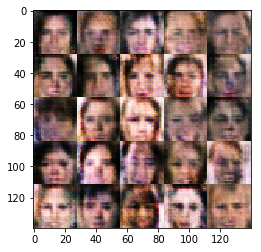

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 1.4277


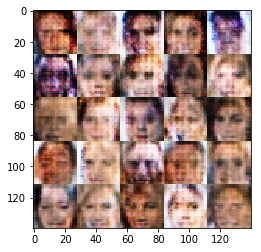

Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 1.0684


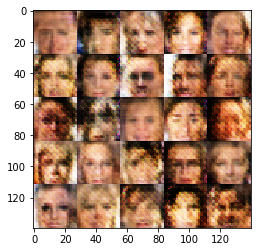

Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.7701... Generator Loss: 2.9070
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.6864


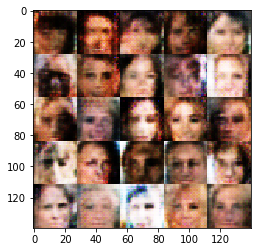

Epoch 1/1... Discriminator Loss: 2.8255... Generator Loss: 2.5155
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.8113... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8121


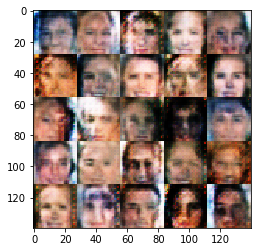

Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.6554


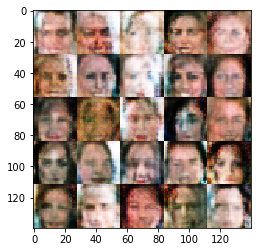

Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.6793


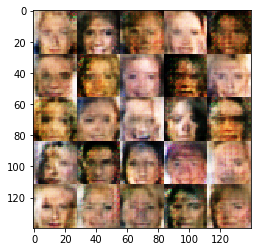

Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7425


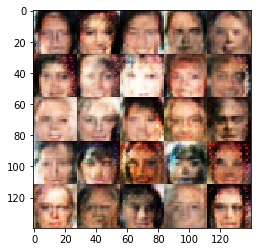

Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.4241
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 1.5825


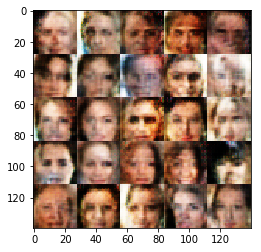

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.7808


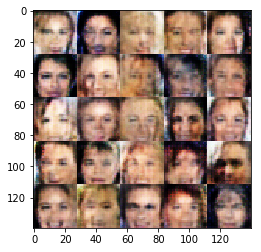

Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 2.1587... Generator Loss: 0.2099


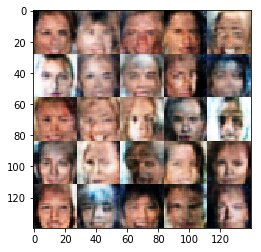

Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.9205... Generator Loss: 0.2266
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7075


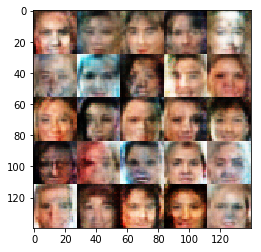

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 2.1357
Epoch 1/1... Discriminator Loss: 2.2421... Generator Loss: 1.7653
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 1.9956
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 1.7588
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 3.6391


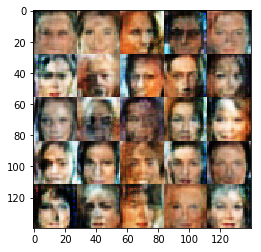

Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.8152
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.3448
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 2.1485
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 1.4626


Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.0764... Generator Loss: 3.0223
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 3.0246
Epoch 1/1... Discriminator Loss: 0.1265... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.2429
Epoch 1/1... Discriminator Loss: 4.1021... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5196


Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9514


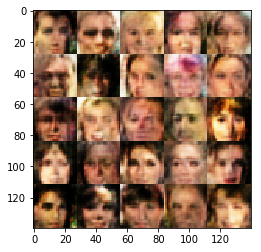

Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 2.0090... Generator Loss: 4.1502
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 2.3643
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.9374... Generator Loss: 1.4540


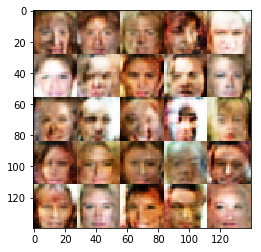

Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.4700
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 4.0168
Epoch 1/1... Discriminator Loss: 0.0638... Generator Loss: 3.3817
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 2.3643... Generator Loss: 0.1707
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.1439


Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5804


Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5626


Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.0970
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.6270


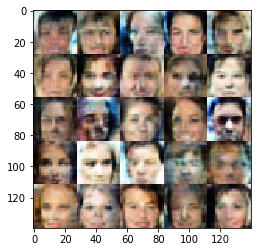

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6000


Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 0.8642


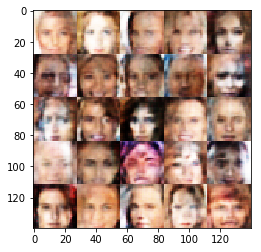

Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 1.6459
Epoch 1/1... Discriminator Loss: 2.0760... Generator Loss: 0.2023
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 1.7529
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 3.5830
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.9134
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 1.6324
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 2.0168


Epoch 1/1... Discriminator Loss: 2.4331... Generator Loss: 2.8321
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 2.0567
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 1.7333
Epoch 1/1... Discriminator Loss: 3.1832... Generator Loss: 3.2729


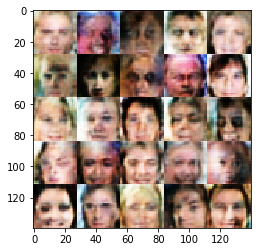

Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 3.3682
Epoch 1/1... Discriminator Loss: 0.0580... Generator Loss: 3.2794
Epoch 1/1... Discriminator Loss: 2.8207... Generator Loss: 0.1879
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 3.3221
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 0.9162


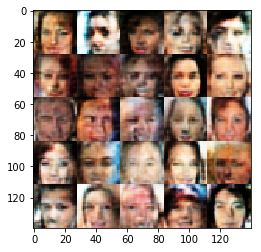

Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 2.8576
Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.4998


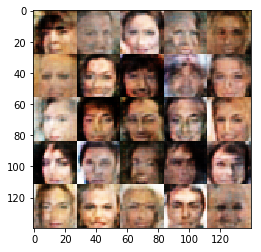

Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.3659
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7683


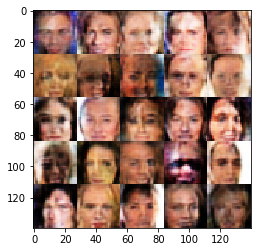

Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 2.8678
Epoch 1/1... Discriminator Loss: 2.0440... Generator Loss: 0.1643
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 2.5270
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 0.8291


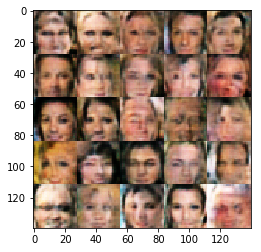

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 3.7371
Epoch 1/1... Discriminator Loss: 1.8889... Generator Loss: 2.4360
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 1.6620
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 0.2052... Generator Loss: 2.7622
Epoch 1/1... Discriminator Loss: 0.0436... Generator Loss: 3.8922
Epoch 1/1... Discriminator Loss: 2.0018... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 3.3782
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.6586... Generator Loss: 4.9483


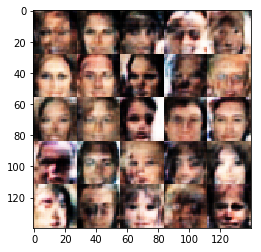

Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 2.4044
Epoch 1/1... Discriminator Loss: 0.3155... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 4.1158
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4309


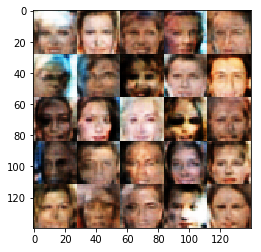

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 2.4100
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.4227
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.2734... Generator Loss: 2.5102
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.3089
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.1617


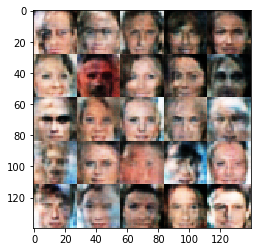

Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 2.9286
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 1.6016
Epoch 1/1... Discriminator Loss: 0.2728... Generator Loss: 1.9772
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.3528


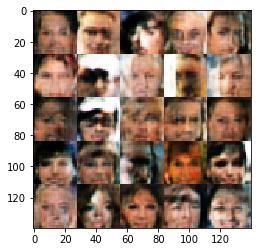

Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 3.2065
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 2.0447... Generator Loss: 0.3040


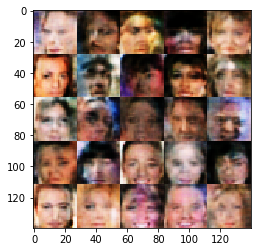

Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 0.0733... Generator Loss: 3.9255
Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 4.9231
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 3.6350
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.0115


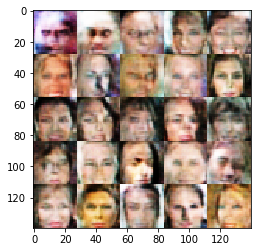

Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 4.1384... Generator Loss: 0.0470
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7147


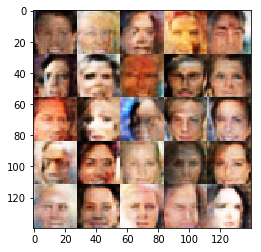

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 2.3131
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.6495
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.5146


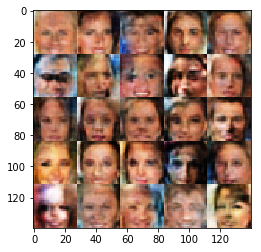

Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 2.8087
Epoch 1/1... Discriminator Loss: 0.1225... Generator Loss: 3.2240
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 2.7945


Epoch 1/1... Discriminator Loss: 0.2708... Generator Loss: 1.7225
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 3.7787
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 4.7014
Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 2.3321
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 5.0485


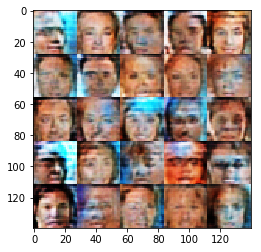

Epoch 1/1... Discriminator Loss: 3.3447... Generator Loss: 4.6679
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 5.3377
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 4.7221
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 2.5385
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 3.4760
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 2.6473
Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 2.9835
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 3.2178


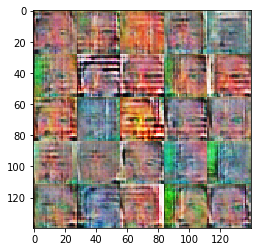

Epoch 1/1... Discriminator Loss: 0.2290... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.1052... Generator Loss: 7.5337
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 6.9296
Epoch 1/1... Discriminator Loss: 6.3221... Generator Loss: 5.5974
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 7.0221
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 6.4921
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.3828


Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.7972... Generator Loss: 0.2467
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.5074


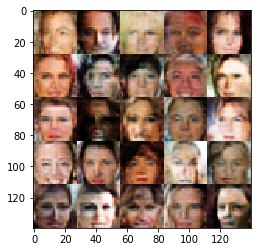

Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.5014


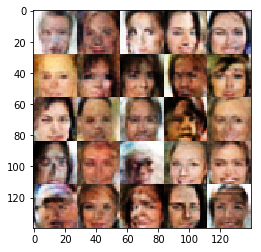

Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 4.3882
Epoch 1/1... Discriminator Loss: 0.0980... Generator Loss: 2.9698
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.1639
Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 1.8493
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.0056


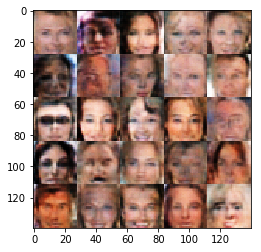

Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 2.2243
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.1300


Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 2.1142
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 2.3565
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.3516


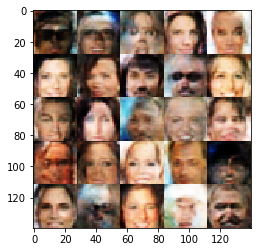

Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 2.5407
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 2.3687
Epoch 1/1... Discriminator Loss: 2.1545... Generator Loss: 2.9306


Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 2.8138
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 3.2628
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 2.0561
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.1346


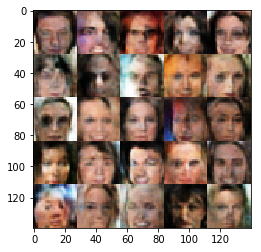

Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.1198... Generator Loss: 2.5036
Epoch 1/1... Discriminator Loss: 0.0815... Generator Loss: 2.9631
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 4.8492
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 5.4371


Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 6.4223
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 3.7648
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 3.8651
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.9042
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.7298
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 4.1117
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 6.3217
Epoch 1/1... Discriminator Loss: 0.0396... Generator Loss: 3.8429
Epoch 1/1... Discriminator Loss: 0.0521... Generator Loss: 3.5707
Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 4.8212


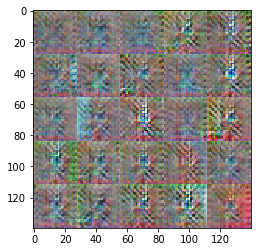

Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 5.2752
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 4.4858
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 4.6533
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 4.5706
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 4.7771
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 4.2640
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 5.6450
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 5.6651
Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 5.6032
Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 4.8033


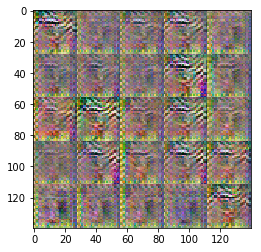

Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 5.4606
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.0915
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 8.5974
Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 6.5911
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 5.0808
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.8664
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 8.1671
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 4.8692
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 5.8741
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 8.0316


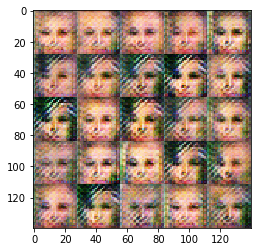

Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 12.8005
Epoch 1/1... Discriminator Loss: 2.1209... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.5413
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 6.8509
Epoch 1/1... Discriminator Loss: 0.2636... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 5.2804
Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 5.9958
Epoch 1/1... Discriminator Loss: 7.3150... Generator Loss: 0.0046
Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 4.3381


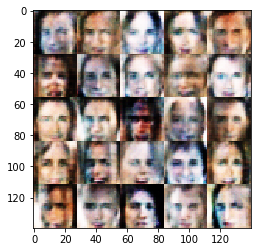

Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 5.5677
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 1.7247
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.1298... Generator Loss: 3.0323
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 5.4198
Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 2.6134
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 6.6369
Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 3.3740
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 6.8459
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 4.4135


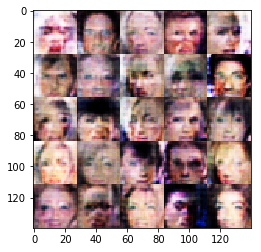

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 2.1953
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.6825
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 1.8895
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 2.3920
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.3147


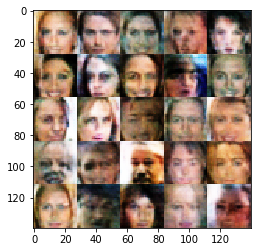

Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.8466
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.3243... Generator Loss: 1.9696
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.3654


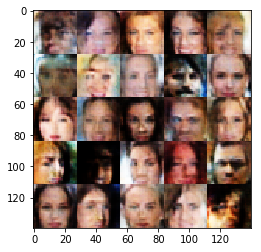

Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 2.4203
Epoch 1/1... Discriminator Loss: 2.1928... Generator Loss: 0.2109
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 2.2926... Generator Loss: 1.7269


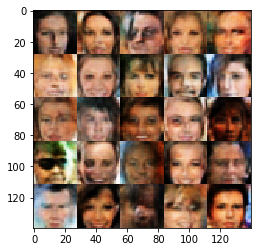

Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 0.3181... Generator Loss: 1.5586


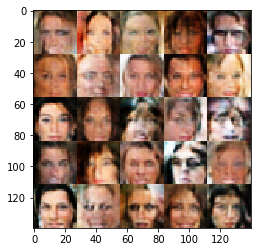

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.2276


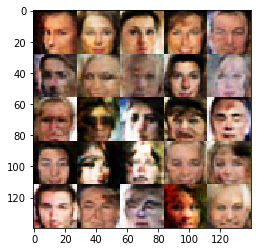

Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 4.8130
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.5816


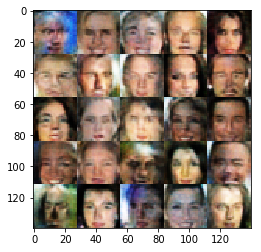

Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.3345
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 0.6666


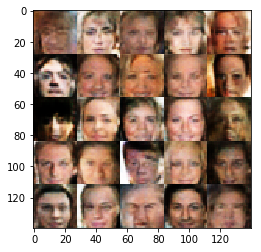

Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.2355


In [13]:
batch_size = 28
z_dim = 128
learning_rate = 0.0028
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.